# 03 - Pipeline Principal (Registro de 3 imágenes) — Versión completa

Este notebook realiza el registro de las **tres** imágenes del comedor, calcula homografías, genera un panorama
blend con feathering, calibra la escala usando el cuadro (117 cm) y permite medir objetos.

Asegúrese de ejecutar este notebook en la raíz del proyecto donde existe la carpeta `src/`.


In [1]:
# Imports y carga de módulos locales
import sys, os
from pathlib import Path

sys.path.append(str(Path.cwd().parent))
from src.feature_detection import detect_and_describe
from src.matching import flann_match, bf_match, ratio_test_filter
from src.registration import stitch_three_images
from src.measurement import compute_scale_from_reference, interactive_measurement, pixels_distance
from src.utils import read_img, draw_keypoints
import cv2, numpy as np
import matplotlib.pyplot as plt
print('Modules imported')


Modules imported


Shapes: (869, 1159, 3) (869, 652, 3) (869, 652, 3)


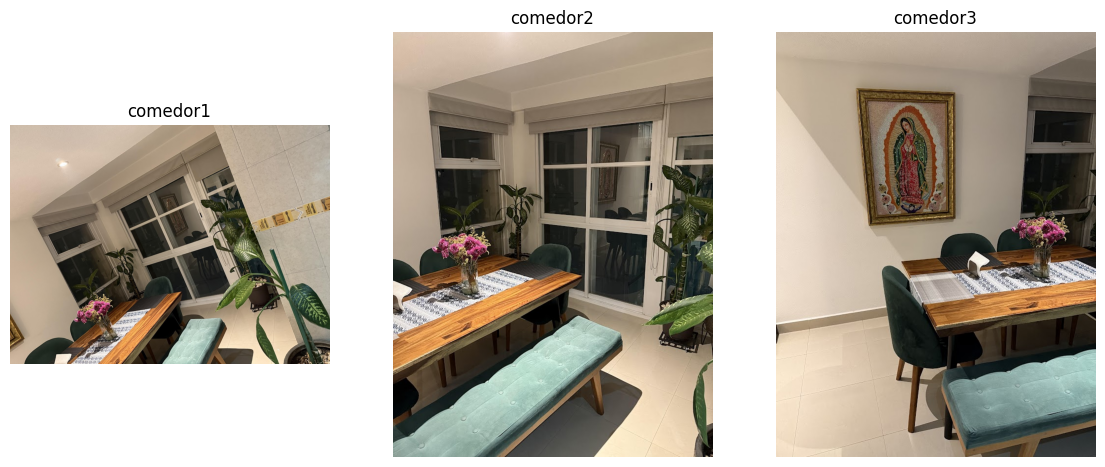

In [2]:
# Cargar las 3 imágenes (BGR) desde data/original
img1 = read_img('../data/original/comedor1.jpg')
img2 = read_img('../data/original/comedor2.jpg')
img3 = read_img('../data/original/comedor3.jpg')
print('Shapes:', img1.shape, img2.shape, img3.shape)
plt.figure(figsize=(14,6));
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)); plt.title('comedor1'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)); plt.title('comedor2'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)); plt.title('comedor3'); plt.axis('off')
plt.show()


## Detección y visualización de keypoints (ejemplo con SIFT/ORB)


Keypoints: 2942 1319 1147


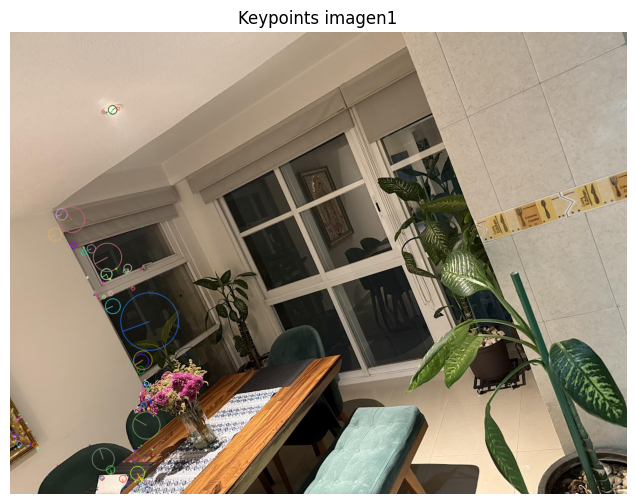

In [3]:
# Detectar keypoints en cada imagen, con fallback a ORB en caso de SIFT no disponible
def detect_safe(img, method='SIFT'):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    try:
        kp, des = detect_and_describe(gray, method=method)
    except Exception as e:
        print('Falling back to ORB due to:', e)
        kp, des = detect_and_describe(gray, method='ORB')
    return kp, des

kp1, des1 = detect_safe(img1, method='SIFT')
kp2, des2 = detect_safe(img2, method='SIFT')
kp3, des3 = detect_safe(img3, method='SIFT')
print('Keypoints:', len(kp1), len(kp2), len(kp3))
kimg1 = draw_keypoints(img1, kp1, max_kpts=200)
plt.figure(figsize=(10,6)); plt.imshow(cv2.cvtColor(kimg1, cv2.COLOR_BGR2RGB)); plt.title('Keypoints imagen1'); plt.axis('off'); plt.show()


## Matching y estimación de homografías (1<->2 y 1<->3)


Good matches 1-2: 439 Good matches 1-3: 230


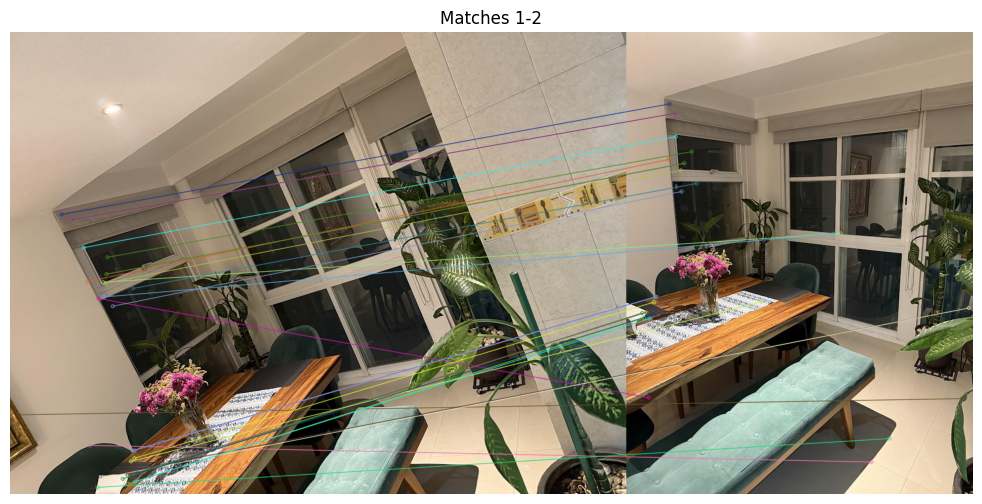

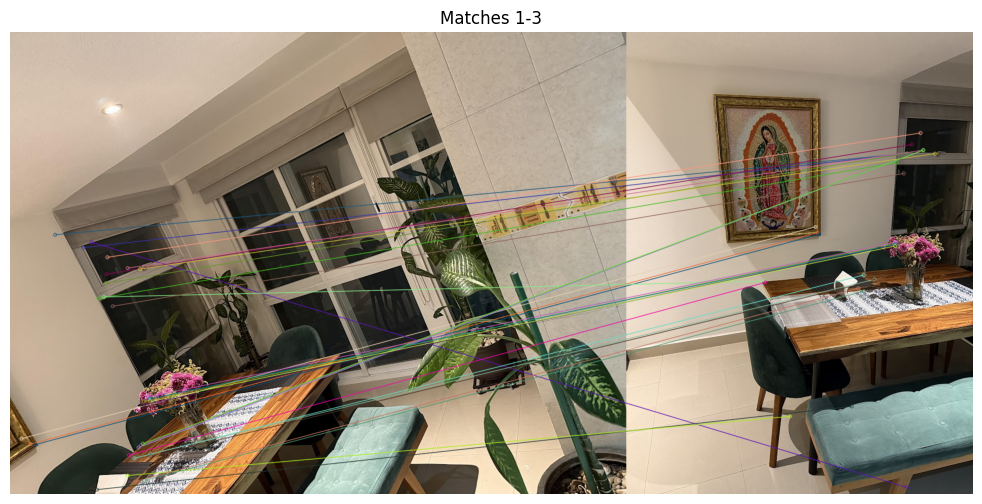

In [4]:
# Perform matching 1<->2 and 1<->3 using FLANN (with fallback)
def match_safe(d1, d2):
    try:
        matches_knn = flann_match(d1, d2, k=2)
    except Exception as e:
        print('FLANN failed, fallback to BFMatcher:', e)
        matches_knn = bf_match(d1, d2)
    return matches_knn

m12 = match_safe(des1, des2)
m13 = match_safe(des1, des3)
good12 = ratio_test_filter(m12, ratio=0.75)
good13 = ratio_test_filter(m13, ratio=0.75)
print('Good matches 1-2:', len(good12), 'Good matches 1-3:', len(good13))
# Visualize top matches
img_m12 = cv2.drawMatches(img1, kp1, img2, kp2, good12[:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_m13 = cv2.drawMatches(img1, kp1, img3, kp3, good13[:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(14,6)); plt.imshow(cv2.cvtColor(img_m12, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title('Matches 1-2'); plt.show()
plt.figure(figsize=(14,6)); plt.imshow(cv2.cvtColor(img_m13, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title('Matches 1-3'); plt.show()


In [5]:
# Estimate homographies using the helper from src/registration
from src.registration import find_homography_ransac
H12, mask12 = find_homography_ransac(kp1, kp2, good12, ransac_thresh=5.0) if len(good12) >=4 else (None,None)
H13, mask13 = find_homography_ransac(kp1, kp3, good13, ransac_thresh=5.0) if len(good13) >=4 else (None,None)
print('H12 is None?', H12 is None, 'H13 is None?', H13 is None)
if H12 is not None:
    print('H12 first row:', H12[0])
if H13 is not None:
    print('H13 first row:', H13[0])


H12 is None? False H13 is None? False
H12 first row: [  1.217675     0.47533664 -59.83442776]
H13 first row: [ 2.73932767e+00  1.24077577e+00 -1.37726047e+03]


In [6]:
import inspect
print("repr:", repr(detect_and_describe))
print("type:", type(detect_and_describe))
try:
    print("signature:", inspect.signature(detect_and_describe))
except Exception as e:
    print("no signature:", e)
print("callable?:", callable(detect_and_describe))

repr: <function detect_and_describe at 0x0000027F6419AC00>
type: <class 'function'>
signature: (img: numpy.ndarray, method: str = 'SIFT') -> Tuple[List[cv2.KeyPoint], numpy.ndarray]
callable?: True


## Registro completo de las 3 imágenes y blending


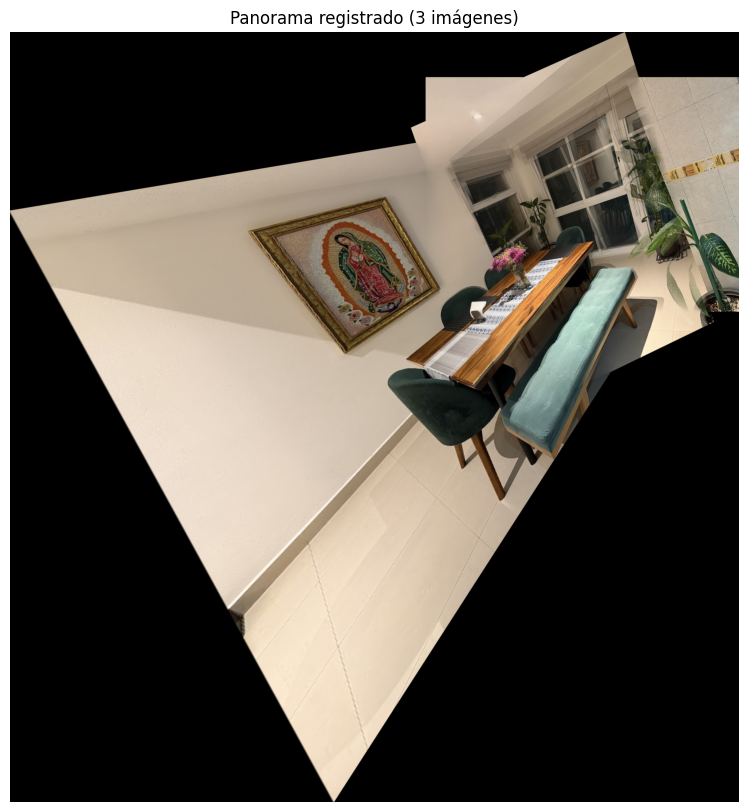

Panorama guardado en results/figures/panorama_registered_complete.png


In [7]:
# Use the improved stitch_three_images to generate panorama and save it
try:
    pano, Hs = stitch_three_images(img1, img2, img3, detector_fn=detect_and_describe, matcher_fn=flann_match, method='SIFT', ratio=0.75)
    pano_rgb = cv2.cvtColor(pano, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16,10)); plt.imshow(pano_rgb); plt.axis('off'); plt.title('Panorama registrado (3 imágenes)'); plt.show()
    os.makedirs('../results/figures', exist_ok=True)
    cv2.imwrite('../results/figures/panorama_registered_complete.png', pano)
    print('Panorama guardado en results/figures/panorama_registered_complete.png')
except Exception as e:
    print('Error durante el cosido:', e)
    print('Si falla, intente cambiar method="ORB" en el llamado.')


## Calibración métrica usando el cuadro (117 cm)

Usamos las coordenadas de ejemplo guardadas en `data/original/example_coords.json` para extraer la altura del cuadro en píxeles
en la imagen base (referencia) y así calcular metros/pixel.


In [8]:
import json
with open('../data/original/example_coords.json') as f:
    coords = json.load(f)
pt, pb = coords['picture_top'], coords['picture_bottom']
pixel_height = abs(pb[1]-pt[1])
real_height_m = 1.17  # 117 cm
meters_per_pixel = compute_scale_from_reference(pixel_height/100.0, real_height_m)
print(f'Pixel height of picture: {pixel_height} px (example)')
print('Estimated meters per pixel (example):', meters_per_pixel)


Pixel height of picture: 260 px (example)
Estimated meters per pixel (example): 0.44999999999999996


## Medición de un objeto en el panorama


In [ ]:
from src.measurement import measure_in_meters
tl = coords['table_left']
tr = coords['table_right']
px_dist = pixels_distance(tl, tr)
dist_m = measure_in_meters(tl, tr, meters_per_pixel)
print(f'Tabla: {px_dist:.1f} px -> {dist_m:.3f} m (ejemplo)')


Tabla: 145.3 px -> 65.368 m (ejemplo)


## Guardar resultados y conclusiones
Guarde las imágenes generadas y un pequeño informe con los parámetros utilizados.


In [10]:
with open('../results/measurements/pipeline_report.txt','w') as f:
    f.write('Panorama generado: results/figures/panorama_registered_complete.png\n')
    f.write(f'Meters per pixel (example): {meters_per_pixel}\n')
print('Reporte guardado en results/measurements/pipeline_report.txt')


Reporte guardado en results/measurements/pipeline_report.txt
